##### Algorithm Theoretical Basis Document: Jupyter Notebook Implementation of Algorithms to Validate NISAR L2 Secular Requirement

*Version 2.1*

*April 20, 2022*

*NISAR Solid Earth Team*

<hr/>

## 1.1 Motivation: Secular Velocities
The measurement of secular velocities plays an essential role in our understanding of fundamental processes associated with tectonic deformation and post-glacial rebound, along with many other gradual and steady processes that deform the Earth’s surface. Secular velocities in the context of NISAR also refer to the approximately constant velocity fields for other applications with time scales exceeding the operational lifetime of the mission.

## 2.1 Requirements
**L2 Requirement 658 - Secular Deformation Rates:** *Over three years, the NISAR project shall measure at least two components of the spatially and temporally averaged relative vector velocities over active regions of Earth’s land surface with accuracy of 2 mm/yr or better, over length scales 0.1 km < L < 50 km, over 70% of these regions*

The NISAR mission identifies actively deforming regions of Earth using the Kreemer et al. (2014) Global Strain Rate Model (GSRM). Regions are defined as active if the GSRM indicates strain in excess of 20 ns/yr or 1 mm/yr over 50 km, and are identified in the Secular Deformation Targets Map in Appendix H of the NISAR handbook (2018). To meet the requirement, NISAR must be able to constrain displacements in two look directions (left-looking on both ascending and descending tracks) for 70% of the active regions with an accuracy of 2 mm/yr root-mean-square. By relative vector velocities we refer to the difference in measured velocity between any two points over the three years. This requirement refers to secular velocities measured over up to three years. In areas with high correlation, several acquisitions spanning the three years may be sufficient, while in other areas many acquisitions would be needed. This requirement applies to 70% of the area of active regions imaged by NISAR. Decorrelation or significant atmospheric artifacts may preclude the formation of high-quality interferograms in some areas.

## 2.2 Approach to validating the L2 requirements

We use [two] approaches [in this notebook] for validating the NISAR Solid Earth Science L2 requirements. All approaches require L2 data inputs in the form of unwrapped NISAR interferograms over calibration/validation (calval) targets that sample a range of vegetation types, topographic relief, and strain rates.  Requirement 663 requires individual interferograms only. Requirements 658 and 660 require a set of temporally contiguous/overlapping SAR interferograms over all time periods of interest, from which deformation timeseries can be generated (see description of inputs and potential preprocessing steps in Sections 3 and 5). 

For Validation Approach \#1, we compare InSAR-derived surface displacements with point observations of surface motion from collocated continuous GNSS stations (hereafter we refer to continuous GNSS simply as “GNSS”). Since all requirements are written in terms of relative displacements between individual points within the deformation field, comparisons are done using the differences of observed surface motion (from both InSAR and GNSS) between GNSS station locations. For a GNSS station network of _N_ stations located within an interferogram, this will yield _N(N-1)/2_ distinct observations for comparison, distributed across a range of length scales. As we discuss below, the methodology differs slightly depending on whether we perform our comparison using displacements from single interferograms (Requirement 663) or using basis functions fit to deformation time series derived from many interferograms (Requirements 658, 660), but the underlying premise is the same: that GNSS provides a sufficiently high-quality time series to validate InSAR observations. This approach is appropriate where measurable displacements are occurring across the cal/val region and the GNSS network is sufficiently dense to capture most of the expected spatial variability of the signal. 

For Validation Approach \#2, which is appropriate for negligibly deforming regions, we examine the NISAR interferograms without comparison to GNSS, under the assumption that surface deformation is essentially zero at all relevant spatial scales. This method involves computing InSAR displacement observations at a statistically-significant number of randomly chosen interferogram pixels and confirming that the estimates are consistent with there being no deformation within the scene.

All the Solid Earth Science L2 requirements specify a minimum spatial coverage component, whose validation will rely on a combination of assessing the coverage of InSAR-quality data and ensuring that the required measurement accuracy is achieved in a suite of locations that comprehensively sample different types of regions with respect to surface properties and vegetation land cover. Many of these regions will be automatically evaluated as part of the targeted sites for the transient deformation requirement.

### 2.2.1	L2 Requirement 658 - Secular Deformation Rate

To validate relative secular deformation rates (or velocities) from NISAR, we use Line-of-Sight (LOS) velocity data for each coherent pixel in a target region. We generate separate LOS velocities for ascending and descending passes to meet the requirement for two components of motion over each target location. Although the requirement specifies that the validation span 3 years of data, we can perform the validation for periods shorter than 3 years provided we mitigate annual effects by using data that span multiples of 1 year, or by explicitly modeling and removing the seasonal displacements. The relative vector velocity between any two points in the scene will be taken as the difference in the LOS velocity at those points. 

In **Validation Approach \#1**, we use the LOS velocity product to calculate the relative InSAR velocity between each pair of GNSS stations within the SAR footprint that are less than 50 km apart. We then generate the accompanying GNSS velocity differences by projecting the 3-component GNSS position time series into the InSAR LOS direction, estimating the GNSS LOS velocities, and differencing the GNSS LOS velocities between all station pairs. To test NISAR’s fulfillment of the 2 mm/yr specification, we difference the InSAR and GNSS relative velocity estimates for each pair, and **DISCUSS STATISTICAL TEST HERE.** 

**Validation Approach \#2** is identical to Approach \#1 except that the relative velocities are determined for random pairs of InSAR pixels within a scene, and the statistics are calculated directly from the InSAR estimates for an area with no deformation. The cal/val regions to be used for both approaches will be defined by the NISAR Science Team and listed in the NISAR cal/val document.

## 2.3.	Technical Framework for Validating Requirements
All of the analyses below will be performed independently on ascending and descending NISAR scenes to meet the terms of the L2 requirements.

### 2.3.1.	Generalized Time Series Analysis
The InSAR and GNSS comparisons for Requirements 658 and 660 described in Section 2.2 will be performed in the framework of generalized time series analysis whereby information in each time series is characterized by one or more underlying basis functions. The problem is cast as an overdetermined least squares (LSQ) estimation problem, from which we infer parameters for the simultaneous fit of various components to the time series, on a station-by-station or pixel-by-pixel basis. We describe our implementation of this approach in Section 4.

These components––which include secular velocities, seasonal sinusoids, temporal offsets, and postseismic exponential decay––represent much of the non-stochastic variance in the time series and are well-suited to the specific validation targets. To perform the validations in Section 2.2, estimates of the fit parameters for these functions (rather than the raw time series themselves) will be used.  For Requirement 658 (secular deformation) we will use the velocity component of these fits, while for Requirement 660 (coseismic deformation) we will use the velocity, Heaviside (instantaneous step), and exponential/logarithmic components. 

### 2.3.2.	Spatial Analysis of InSAR scenes
Covariance analysis of individual unwrapped interferogram (Requirement 663) or modeled displacement image from generalized time series analysis (Requirement 658 and 660) in non-deforming regions will be conducted at the required spatial resolutions. We first estimate the covariances or semi-variogram of phase observations between points of varying distances by constructing the structure function (e.g., Lohman & Simons, 2005) (see Section 4.2). We then compare the spatial spectrum of the covariance function to the requirement(s) at distances between 0.1 and 50 km  to validate that the observed noise is smaller than the threshold in the various requirements. We use ensemble statistics over different terrains and seasons for this validation approach. SES members have done relevant work in the past to validate the NISAR performance tool (Hensley et al., 2016) using the  70-km swath of ALOS interferograms. Before the NISAR launch, we can use ALOS-2 wide-swath or Sentinel-1 scenes to conduct this validation.

<hr/>

# Workflow to Validate NISAR L2 Secular Displacement Requirement

**Original code authored by:** David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun 

## 3.1 Interferogram Stack Preparation
>A. Generate Interferograms Using ASF's Vertex  
 B. Configure Local Processing Environment  
 C. Download Interferograms from the ASF archive

## 3.2. Generation of Time Series from Interferogram Stack
>A. Crop Interferograms to Analysis Region      
 B. Set Up MintPy Configuration file  
 C. Load data into MintPy  
 D. Validate/Modify Interferogram Network  
 E. Generate Quality Control Mask  
 F. Reference Interferograms To Common Lat/Lon  
 G. Invert for SBAS Line-of-Sight Timeseries

## 3.3. Optional Time Series Corrections
>A. Solid Earth Tides Correction  
 B. Trospheric Delay Correction  
 C. Phase Deramping  
 D. Topographic Residual Correction  

## 4.1 Estimate InSAR and GNSS Velocities
>A. Estimate InSAR LOS Velocities  
 B.  Find Collocated GNSS Stations  
 C.  Get GNSS Position Time Series  
 D.  Make GNSS LOS Velocities  
 E.  Re-Reference GNSS and InSAR Velocities

## 4.2 NISAR Validation Approach 1: GNSS-InSAR Comparison
>A.  Make Velocity Residuals at GNSS Station Locations  
 B.  Make Double-Differenced Velocity Residuals  
 C.  Secular Requirement Validation

## 4.3 NISAR Validation Approach 2: InSAR-Only Structure Function


## Appendix 1: Supplementary Comparisons and Plots
> A. Compare Raw Velocities  
  B. Plot Velocity Residuals  
  C. Plot Double-Differenced Residuals  
  D. Plot displacements and velocity timeseries at GNSS station locations


# 3.1 Stack Preparation
In this initial processing step, all the necessary Level-2 unwrapped interferogram products are gathered, organized and reduced to a common grid for analysis MintPy. Ascending and descending stacks of nearest-neighbor and skip-1 interferograms will be prepared for independent analysis. 

### 3.1.A  Generate Interferogram Stack
The project will provide sets of fully coregistered and geocoded ascending and descending unwrapped L2 interferograms (aka InSAR “stacks”) over regions of interest listed in the NISAR Solid Earth Science cal/val document. As part of L2 processing, the project will calculate and apply required (and possibly optional) corrections to minimize errors due to non-geophysical sources. An example of a required correction is the removal of ionospheric propagation delays using split-band processing.

InSAR stacks will include at a minimum nearest-neighbor and skip-1 interferograms to mimic the planned standard L2 data product from NISAR and will span a minimum of 2 years to support full testing of the validation algorithms for all three L2 requirements (including the fitting of seasonal basis functions to the InSAR time series). A more complete set of interferograms, including pairs spanning longer periods, may be requested for regions with higher vegetation cover, soil moisture and/or snow cover variability.  For the purpose of testing ATBD algorithms prior to NISAR launch, the NISAR SES team will make interferogram stack using SAR data from complementary missions (e.g., Sentinel-1 or ALOS-2). 

For operational NISAR processing (using ARIA as of this ATBD revision), the following information will be provided in the Level-2 products provided for NISAR SES L2 requirements validation: 

  + Unwrapped ionosphere-corrected interferograms (either in radar or ground coordinates) following the L1 and L2 product descriptions summarized in the NISAR Handbook (2018).  The spatial resolution of the interferograms must be 100 m or better (in order to address requirements 660 and 663).
  + Corresponding coherence.
  + Perpendicular baseline associated with the interferograms.
  + Radar simulation containing the pixel elevations.
  + Radar incidence angles for each InSAR pixel
  + Shadow, layover and land/water masks corresponding to the interferograms. 
  + Configuration that includes processing parameters such as coherence thresholds, flags for applying phase corrections etc. to allow for region-specific customization.
  + Solid Earth tide phase screen 
  + Optional: Atmospheric delay metadata
  + Optional: Ocean tidal load response

### 3.1.B  Configure Local Processing Environment

In [3]:
#Load Packages
import math
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pickle
import pylab
import zipfile
from datetime import datetime as dt
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
from mintpy.utils import readfile, utils as ut
from mintpy.objects import gps
from mintpy.objects.gps import GPS
from pathlib import Path
from scipy import signal
from scipy.stats import chi2

In [4]:
#Set Custom Parameters
calval_dir = '/Users/aborsa/Dropbox/missions/nisar/jupyter/calval/'
calval_location = 'central_valley'
download_region = '"36.18 36.26 -119.91 -119.77"' #download box in S,N,W,E format
analysis_region = '"35.77 36.75 -120.61 -118.06"' #analysis box in S,N,W,E format (must be within download_region)
download_start_date = '20180101'
download_end_date = '20180801'
sentinel_track = '144'

#Set Directories
work_dir = f"{calval_dir}{calval_location}/"
print("Work directory: ", work_dir)
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
mint_dir = work_dir + 'MintPy/'
if not os.path.isdir(mint_dir):
    os.makedirs(mint_dir)
gunw_dir = work_dir + 'products/'
mint_source_dir = '/opt/anaconda3/tools/MintPy/mintpy/defaults/'

#Set Filenames to enable restarting in middle of notebook
config_file = calval_location + '_Sen.cfg'
geom_file = os.path.join(mint_dir, 'inputs/geometryGeo.h5')
msk_file = os.path.join(mint_dir, 'maskTempCoh.h5')
vel_file = os.path.join(mint_dir, 'velocity.h5')

Work directory:  /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/


In [5]:
#Verify MintPy Installation
try:
    from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
except ImportError:
    raise ImportError("Looks like mintPy is not fully installed")

#Set Global Plot Parameters
plt.rcParams.update({'font.size': 12})

### 3.1.C  Download (Aria) Interferograms from ASF

In [10]:
# download all interferograms that intersect download_region over specified time range
os.chdir(work_dir)
command = 'ariaDownload.py --bbox ' + download_region + ' --start ' + download_start_date + ' --end ' + download_end_date 
if sentinel_track != '':
    command = command + ' --track ' + sentinel_track
os.system(command + ' -o Count');
#os.system(command);

#delete unnecessary files
if os.path.exists(gunw_dir + "avg_rates.csv"):
  os.remove(gunw_dir + "avg_rates.csv")
if os.path.exists(gunw_dir + "ASFDataDload0.py"):
  os.remove(gunw_dir + "ASFDataDload0.py")
if os.path.exists(gunw_dir + "AvgDlSpeed.png"):
  os.remove(gunw_dir + "AvgDlSpeed.png")
if os.path.exists(gunw_dir + "error.log"):
  os.remove(gunw_dir + "error.log")
if os.path.exists(work_dir + "error.log"):
  os.remove(work_dir + "error.log")

ARIA-tools Version: 0
https://api.daac.asf.alaska.edu/services/search/param?asfplatform=Sentinel-1%20Interferogram%20(BETA)&processingLevel=GUNW_STD&output=JSON&relativeOrbit=144&bbox=-119.91,36.18,-119.77,36.26

Found -- 44 -- products


# 3.2 Generation of Time Series from Interferograms
InSAR time series (i.e., the unfiltered displacement of each pixel vs. time) are estimated from a processed InSAR stack from Section 3.1 (either ascending or descending) using a variant of the small baseline subset (SBAS) approach and then parameterized using the approach described in Section 4. This step uses tools available in the MintPy software package (REF), which provides both SBAS time series and model-based time series parameterization. Recent results on InSAR closure phase and “fading signal” recommend the of use all available interferograms to avoid systematic bias (_Ansari et al._, 2020; _Zheng Y.J. et al._, 2022). As we expect high-quality orbital control for NISAR, we anticipate that the interferogram stack will typically include all nearest-neighbor (i.e., ~12-day pairs) and skip-1 interferograms, which will be the minimum inputs into the SBAS generation step.

We use the open-source ARIA-tools package to download processed L2 interferograms over selected cal/val regions from the Alaska Satellite Facility archive and to stitch/crop the frame-based NISAR GUNW products to stacks that can be directly ingested into MintPy for time-series processing. ARIA-tools uses a phase-minimization approach in the product overlap region to stitch the unwrapped and ionospheric phase, a mosaicing approach for coherence and amplitude, and extracts the geometric information from the 3D data cubes through a mosaicking of the 3D datacubes and subsequent intersection with a DEM. ARIA has been used to pre-process NISAR beta products derived from Sentinel-1 which have revealed interseismic deformation and creep along the San Andreas Fault system, along with subsidence, landsliding, and other signals. 

We use MintPy to validate and modify the InSAR stack, removing interferograms that do not meet minimum coherence criteria, generating a quality control mask for the purpose of identifying noisy pixels within the stack, and referencing estimated deformation to a common location in all interferograms.

### 3.2.A  Crop Interferograms

In [11]:
command = 'ariaTSsetup.py -f "products/*.nc" -b ' + analysis_region + ' --mask Download  --croptounion'
os.system(command);

ARIA-tools Version: 0
*****************************************************************
*** Time-series Preparation Function ***
*****************************************************************
Shapefile ./user_bbox.json created for input user bounds.
Multi-core version
All (86) GUNW products meet spatial bbox criteria.
Group GUNW products into spatiotemporally continuous interferograms.
All (86) interferograms are spatially continuous.
Thread count specified for gdal multiprocessing = 2
Download/cropping DEM
Applied cutline to produce 3 arc-sec SRTM DEM: ./DEM/SRTM_3arcsec.dem
***Downloading water mask... ***

Extracting unwrapped phase, coherence, and connected components for each interferogram pair
Generating: unwrappedPhase - [==================================================] 20181229_20181217    0s /     0s
Generating: coherence - [==================================================] 20181229_20181217   40s /     0s 

Extracting single incidence angle, look angle and azimuth ang

### 3.2.B  Set Up MintPy Configuration file

The default processing parameters for MintPy's **smallbaselineApp.py** need to be modified by including the following lines in config_file (which must be manually created and placed into mint_dir):

- mintpy.load.processor      = aria
- mintpy.load.unwFile        = ../stack/unwrapStack.vrt
- mintpy.load.corFile        = ../stack/cohStack.vrt
- mintpy.load.connCompFile   = ../stack/connCompStack.vrt
- mintpy.load.demFile        = ../DEM/SRTM_3arcsec.dem
- mintpy.load.incAngleFile   = ../incidenceAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.azAngleFile    = ../azimuthAngle/{download_start_date}_{download_edn_date}.vrt
- mintpy.load.waterMaskFile  = ../mask/watermask.msk
- mintpy.reference.lalo      = auto, or somewhere in your bounding box
- mintpy.topographicResidual.pixelwiseGeometry = no
- mintpy.troposphericDelay.method              = no
- mintpy.topographicResidual                   = no

In [12]:
if not os.path.exists(mint_dir + config_file):
    print("Please create custom configuration file as detailed above")

### 3.2.C  Load Data into MintPy
The output of this step is an "inputs" directory in 'calval_directory/calval_location/MintPy/" containing two HDF5 files:
- ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata
- geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.)

In [9]:
#command = 'smallbaselineApp.py ' + config_file + ' --start load data --end velocity'
#added steps to config file:  #6 correct tropo (need to go into pyaps' model.cfg and change user id and password)

In [13]:
os.chdir(mint_dir);
command = 'smallbaselineApp.py ' + config_file + ' --dostep load_data'
os.system(command);
os.system('ls -l inputs/*.h5');

MintPy release version v1.3.1-12, release date 2021-08-19
--RUN-at-2022-04-20 00:12:08.511533--
Current directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: central_valley_Sen
Go to work directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
read custom template file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/central_valley_Sen.cfg
update default template based on input custom template
No new option value found, skip updating /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/cen

### 3.2.D Validate/Modify Interferogram Network
Add additional parameters to config_file in order to remove selected interferograms, change minimum coherence, etc.

MintPy release version v1.3.1-12, release date 2021-08-19
--RUN-at-2022-04-20 00:15:51.454939--
Current directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: central_valley_Sen
Go to work directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
read custom template file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/central_valley_Sen.cfg
update default template based on input custom template
No new option value found, skip updating /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/M

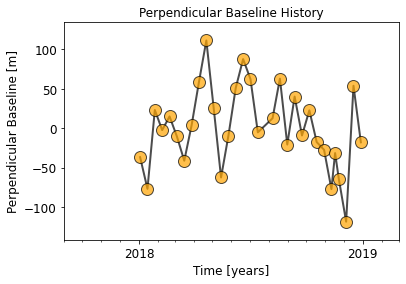

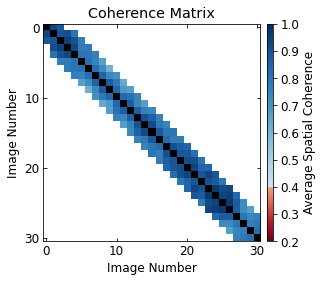

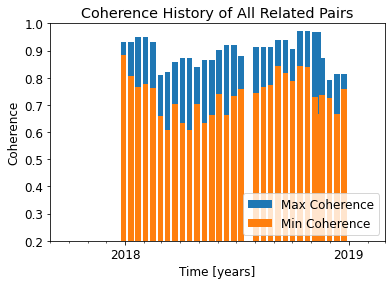

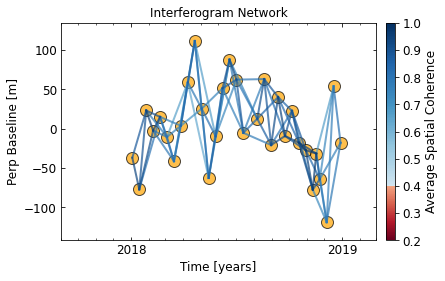

In [14]:
os.chdir(mint_dir);
command = 'smallbaselineApp.py ' + config_file + ' --dostep modify_network'
os.system(command);
plot_network.main(['inputs/ifgramStack.h5'])

### 3.2.E  Generate Quality Control Mask

Mask files can be can be used to mask pixels in the time-series processing. Below we generate a mask file based on the connected components, which is a metric for unwrapping quality.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy release version v1.3.1-12, release date 2021-08-19
input file is mask file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/maskConnComp.h5 in bool format
file size in y/x: (1177, 3061)
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figure size : [15.00, 4.61]
data has uniform and l

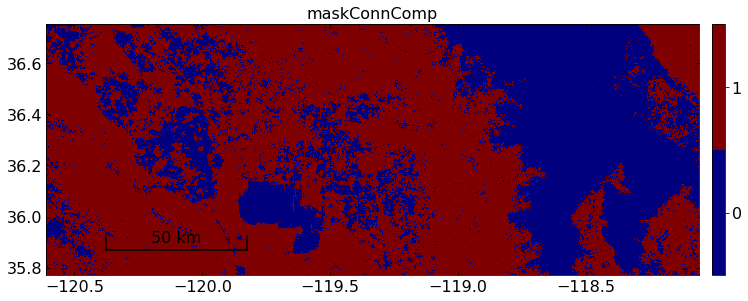

In [15]:
os.chdir(mint_dir);
os.system('generate_mask.py inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update');
view.main(['maskConnComp.h5'])

### 3.2.F  Reference Interferograms To Common Lat/Lon

In [16]:
os.chdir(mint_dir);
command = 'smallbaselineApp.py ' + config_file + ' --dostep reference_point'
os.system(command);
os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

MintPy release version v1.3.1-12, release date 2021-08-19
--RUN-at-2022-04-20 00:31:21.958970--
Current directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: central_valley_Sen
Go to work directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
read custom template file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/central_valley_Sen.cfg
update default template based on input custom template
No new option value found, skip updating /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/smallbaselin

### 3.2.G  Invert for SBAS Line-of-Sight Timeseries

In [17]:
os.chdir(mint_dir);
command = 'smallbaselineApp.py ' + config_file + ' --dostep invert_network'
os.system(command);

MintPy release version v1.3.1-12, release date 2021-08-19
--RUN-at-2022-04-20 00:31:31.021782--
Current directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: central_valley_Sen
Go to work directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
read custom template file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/central_valley_Sen.cfg
update default template based on input custom template
No new option value found, skip updating /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/smallbaselineApp.cfg
copy central_valley_Sen.cfg to inputs   directory fo

# 3.3 Optional Corrections
Phase distortions related to solid earth and ocean tidal effects, as well as those due to temporal variations in the vertical stratification of the atmosphere, can be mitigated using the approaches described below. At this point, it is expected that these corrections will not be needed to validate the mission requirements, but they may be used to produce the highest quality data products. Typically, these are applied to the estimated time series product rather than to the individual interferograms, since they are a function of the time of each radar acquisition.

### 3.3.A Solid Earth Tide Correction
[MintPy provides functionality for this correction.]

### 3.3.B Tropospheric Delay Correction

[MintPy provides functionality for this correction.]

### 3.3.C  Phase Deramping

In [18]:
os.chdir(mint_dir);
command = 'smallbaselineApp.py ' + config_file + ' --dostep deramp'
os.system(command);

MintPy release version v1.3.1-12, release date 2021-08-19
--RUN-at-2022-04-20 00:33:47.793400--
Current directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: central_valley_Sen
Go to work directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
read custom template file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/central_valley_Sen.cfg
update default template based on input custom template
No new option value found, skip updating /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/smallbaselineApp.cfg
copy central_valley_Sen.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
c

### 3.3.D Topographic Residual Correction 
[MintPy provides functionality for this correction.]

# 4.1 Estimate InSAR and GNSS Velocities

The approach that will be used for the generation of NISAR L3 products for Requirements 660 and 663 allows for an explicit inclusion of key basis functions (e.g., Heaviside functions, secular rate, etc.) in the InSAR inversion. Modifications to this algorithm may be identified and implemented in response to NISAR Phase C activities. 

### 4.1.A Estimate InSAR LOS Velocities

In [6]:
os.chdir(mint_dir);
command = 'smallbaselineApp.py ' + config_file + ' --dostep velocity'
os.system(command);
vel = readfile.read(vel_file, datasetName = 'velocity')[0] * 100.  #read and convert velocities from m to cm
# optionally set masked pixels to NaN
#msk = readfile.read(msk_file)[0]
#vel[msk == 0] = np.nan

MintPy release version v1.3.1-12, release date 2021-08-19
--RUN-at-2022-04-20 04:16:23.401101--
Current directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: central_valley_Sen
Go to work directory: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy
read custom template file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/central_valley_Sen.cfg
update default template based on input custom template
No new option value found, skip updating /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/smallbaselineApp.cfg
copy central_valley_Sen.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to inputs   directory for backup.
copy central_valley_Sen.cfg to pic      directory for backup.
copy 

run view.py in MintPy release version v1.3.1-12, release date 2021-08-19
input file is velocity file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/velocity.h5 in float32 format
file size in y/x: (1177, 3061)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 3061, 1177)
subset coverage in y/x: (0, 0, 3061, 1177)
data   coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
subset coverage in lat/lon: (-120.610416667, 36.75125, -118.059584354, 35.770417059)
------------------------------------------------------------------------
colormap: RdBu
figure title: LOS_Velocity
figure size : [15.00, 4.61]
read mask from file: maskTempCoh.h5
set reference pixel to: [200, 1450]
data    range: [-31.33385, 6.434234] cm/year
display range: [-25.0, 25.0] cm/year
display data in transparency: 1.0

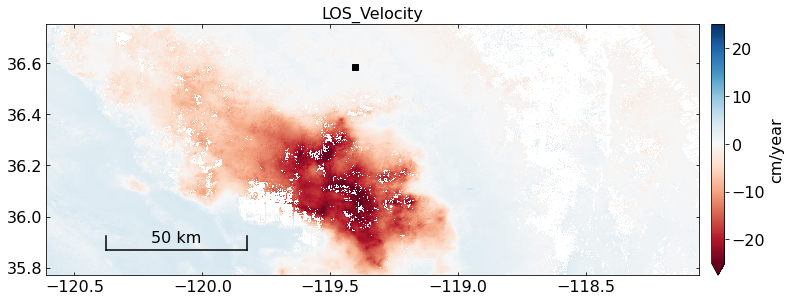

In [7]:
os.chdir(mint_dir);
scp_args = 'velocity.h5 velocity -v -25 25 --ref-yx 200 1450 --colormap RdBu --figtitle LOS_Velocity' # --plot-setting ' + plot_config_file
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

### 4.1.B Find Collocated GNSS Stations
The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

In [8]:
# get analysis metadata from InSAR velocity file
atr = readfile.read_attribute(vel_file)
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
lat_step = float(atr['Y_STEP'])
lon_step = float(atr['X_STEP'])
N = float(atr['Y_FIRST'])
W = float(atr['X_FIRST'])
S = N + lat_step * length
E = W + lon_step * width
start_date = atr.get('START_DATE', None)
end_date = atr.get('END_DATE', None)
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")
inc_angle = int(float(atr.get('incidenceAngle', None)))
az_angle = int(float(atr.get('azimuthAngle', None))) 

#Set GNSS Parameters
gps_completeness_threshold = 0.9     #0.9  #percent of data timespan with valid GNSS epochs
gps_residual_stdev_threshold = 10. #0.03  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

In [9]:
# search for collocated GNSS stations
site_names, site_lats, site_lons = gps.search_gps(SNWE=(S,N,W,E), start_date=start_date, end_date=end_date)
print("Initial list of {} stations used in analysis:".format(len(site_names)))
print(site_names)

Initial list of 54 stations used in analysis:
['BEPK' 'CACO' 'CAFP' 'CAHA' 'CAKC' 'CAND' 'CARH' 'CAWO' 'CRCN' 'DONO'
 'GR8R' 'HELB' 'HOGS' 'HUNT' 'KENN' 'LAND' 'LEMA' 'LONP' 'LOWS' 'MASW'
 'MIDA' 'MNMC' 'MULN' 'P056' 'P281' 'P282' 'P283' 'P292' 'P293' 'P294'
 'P296' 'P297' 'P298' 'P300' 'P304' 'P465' 'P467' 'P531' 'P540' 'P546'
 'P547' 'P566' 'P571' 'P572' 'P573' 'P789' 'P790' 'PKDB' 'POMM' 'RAPT'
 'RNCH' 'TBLP' 'TRAN' 'WLHG']


### 4.1.C Get GNSS Position Time Series

In [10]:
# get daily position solutions for GNSS stations
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_lats = [] 
use_lons = []
counter = 0

for stn in site_names:
    gps_obj = GPS(site = stn, data_dir = mint_dir + 'GPS')
    gps_obj.open()
    
    # count number of dates in time range
    dates = gps_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss,end_date_gnss])
    gnss_count = int(gnss_count[0])
    
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, az_angle)
    #disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, head_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days*gps_completeness_threshold <= gnss_count:
        if stn_stdv > gps_residual_stdev_threshold:
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_lats.append(site_lats[counter])
            use_lons.append(site_lons[counter])
    else:
        bad_stn.append(stn)
    counter+=1

site_names = use_stn
site_lats = use_lats
site_lons = use_lons

calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction
calculating station lat/lon
reading time and displacement in east/north/vertical direction

In [11]:
# [optional] manually remove additional stations
#site_names.remove('P294')
print("Final list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)

Final list of 47 stations used in analysis:
['BEPK', 'CACO', 'CAFP', 'CAHA', 'CAKC', 'CAND', 'CARH', 'CAWO', 'CRCN', 'DONO', 'GR8R', 'HOGS', 'LAND', 'LEMA', 'LOWS', 'MASW', 'MIDA', 'MNMC', 'MULN', 'P056', 'P281', 'P282', 'P283', 'P292', 'P293', 'P294', 'P296', 'P297', 'P298', 'P300', 'P304', 'P465', 'P467', 'P531', 'P540', 'P546', 'P547', 'P566', 'P571', 'P572', 'P573', 'P789', 'P790', 'POMM', 'RNCH', 'TBLP', 'TRAN']
List of 7 stations removed from analysis
['HELB', 'HUNT', 'KENN', 'LONP', 'PKDB', 'RAPT', 'WLHG']


### 4.1.D Make GNSS LOS Velocities

In [12]:
gps_comp = 'enu2los'
site_vels = gps.get_gps_los_obs(
    insar_file=vel_file,
    site_names=site_names,
    start_date=start_date,
    end_date=end_date,
    gps_comp=gps_comp,
    redo=True) * 100.
print(site_vels, site_names)

calculating GPS LOS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 47/47 TRAN   16s /     0s 
write GPS LOS observations to file: /Users/aborsa/Dropbox/missions/nisar/jupyter/calval/central_valley/MintPy/gps_enu2los.csv
[ -0.99066347  -1.4735695   -9.758798   -15.435123    -2.3502321
  -1.3929924   -3.1116898   -0.86118037 -23.299862    -0.51272726
  -0.91863424  -2.3792207   -2.2705464  -14.348825    -2.5765872
  -2.2421772   -1.5229945   -1.1655248   -7.153413   -10.307291
  -1.9184813   -1.5358231   -1.2609155   -1.3869779   -1.1419911
  -1.0546423   -1.0209346   -2.388034    -1.0104302   -0.9645082
  -2.8777633   -0.87083113  -0.7971471   -2.4826155   -1.2941731
  -0.98666084  -1.191282    -2.358363    -0.58138853  -0.76018
  -0.7539495   -1.6260564   -2.4685388   -2.243126    -2.7597535
  -1.4401857   -5.03351   ] ['BEPK', 'CACO', 'CAFP', 'CAHA', 'CAKC', 'CAND', 'CARH', 'CAWO', 'CRCN', 'DONO', 'GR8R', 'H

### 4.1.E  Re-Reference GNSS and InSAR LOS Velocities

In [13]:
gps_ref_site_name = 'CAWO'

# reference GNSS stations to GNSS reference site
ref_site_ind = site_names.index(gps_ref_site_name)
site_vels = site_vels - site_vels[ref_site_ind]

# reference InSAR to GNSS reference site
ref_site_lat = float(site_lats[ref_site_ind])
ref_site_lon = float(site_lons[ref_site_ind])
ref_y, ref_x = ut.coordinate(atr).geo2radar(ref_site_lat, ref_site_lon)[:2]
vel = vel - vel[ref_y, ref_x]

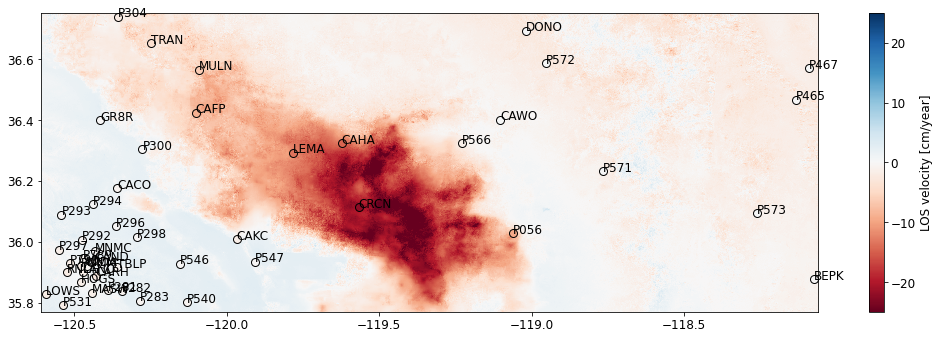

In [14]:
# plot GNSS stations on InSAR velocity field
vmin, vmax = -25, 25
cmap = plt.get_cmap('RdBu')

fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(vel, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS velocity [cm/year]')

for lat, lon, obs in zip(site_lats, site_lons, site_vels):
    color = cmap((obs - vmin)/(vmax - vmin))
    ax.scatter(lon, lat, color=color, s=8**2, edgecolors='k')
for i, label in enumerate(site_names):
     plt.annotate(label, (site_lons[i], site_lats[i]), color='black')

out_fig = os.path.abspath('vel_insar_vs_gnss.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

# 4.2 NISAR Validation Approach 1: GNSS-InSAR Comparison

### 4.2.A Make Velocity Residuals at GNSS Locations

In [15]:
#Set Parameters
pixel_radius = 5   #number of InSAR pixels to average for comparison with GNSS

#Create dictionary with the stations as the key and all their info as an array 
stn_dict = {}  

#Loop over GNSS station locations
for i in range(0,len(site_names)): 
    
    # convert GNSS station lat/lon information to InSAR x/y grid
    stn_lat = site_lats[i]
    stn_lon = site_lons[i]
    x_value = round((stn_lon - W)/lon_step)
    y_value = round((stn_lat - N)/lat_step)
    
    # get velocities and residuals
    vel_GPS = site_vels[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    vel_px_rad = vel[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    vel_InSAR = np.median(vel_px_rad)
    residual = vel_GPS - vel_InSAR

    # populate data structure
    values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]
    stn = site_names[i]
    stn_dict[stn] = values
    
# extract data from structure
res_list = []
insar_vel = []
gnss_vel = []
lat_list = []
lon_list = []
for i in range(len(site_names)): 
    stn = site_names[i]
    insar_vel.append(stn_dict[stn][2])
    gnss_vel.append(stn_dict[stn][3])
    res_list.append(stn_dict[stn][4])
    lat_list.append(stn_dict[stn][5])
    lon_list.append(stn_dict[stn][6])
num_stn = len(site_names) 

### 4.2.B Make Double-Differenced Velocity Residuals

In [ ]:
diff_res_list = []
stn_dist_list = []
dict_keys = list(stn_dict.keys())

# remove reference stn
site_names_analysis = list(site_names)
#site_names_analysis.remove(gps_ref_site_name)

# loop over stations
for i in range(len(site_names_analysis)-1):
    stn1 = dict_keys[i]
    for l in range(i + 1, len(dict_keys)):
        stn2 = dict_keys[l]

        # calculate between-station velocity residual
        # stn_dict values = [x_value, y_value, vel_InSAR, vel_GPS, residual, stn_lat, stn_lon]

        # calculate GNSS and InSAR velocity differences between stations
        gps_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        insar_vel_diff = stn_dict[stn1][2]-stn_dict[stn2][2]

        # calculate GNSS vs InSAR differences (double differences) between stations
        diff_res = gps_vel_diff - insar_vel_diff
        diff_res_list.append(diff_res)

        # get distance (km) between stations using Haversine formula
        # index 5 is lat, 6 is lon
        lat1 = stn_dict[stn1][5]*np.pi/180
        lat2 = stn_dict[stn2][5]*np.pi/180
        dlat = (lat2 - lat1)
        lon1 = stn_dict[stn1][6]*np.pi/180
        lon2 = stn_dict[stn2][6]*np.pi/180
        dlon = (lon2 - lon1)
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        c = 2*np.arctan2(np.sqrt(a),np.sqrt(1 - a))
        dist = 6371*c
        stn_dist_list.append(dist)
                

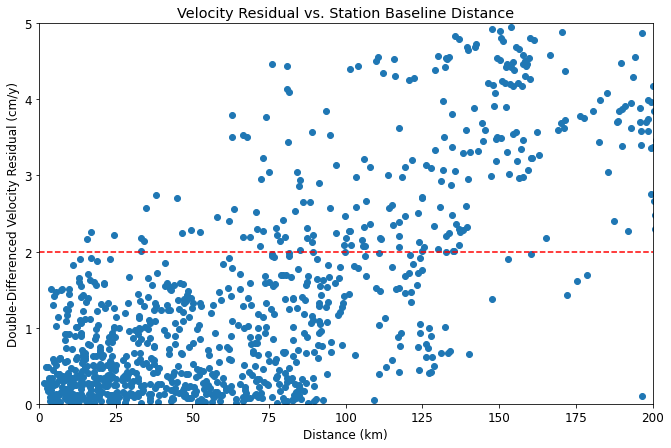

In [19]:
# Write data for statistical tests
dist = [np.array(stn_dist_list)]
rel_measure = [np.array(np.abs(diff_res_list))]
ifgs_date = np.array([[dt.strptime(start_date,"%Y%m%d"),dt.strptime(end_date,"%Y%m%d")]])
n_ifgs = len(dist)

# Plot data to be used below
plt.figure(figsize=(11,7))
plt.scatter(dist,rel_measure)
plt.plot([0,200], [2, 2], 'r--')
plt.ylim(0,5)
plt.xlim(0,200)
plt.xlabel("Distance (km)")
plt.ylabel("Double-Differenced Velocity Residual (cm/y)")
plt.title("Velocity Residual vs. Station Baseline Distance")
plt.show()

### 4.1.C  Secular Requirement Validation: Method 1

In [20]:
# Calculate Statistics

n_bins = 10
threshold = 0.683  
# we assume that the distribution of residuals is Gaussian and 
#  that the threshold represents a 1-sigma limit within which 
#  we expect 68.3% of residuals to lie.

bins = np.linspace(0.1,50.0,num=n_bins+1)
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
n_pass = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points pass
# the final column is the ratio as a whole
for i in range(n_ifgs):
    inds = np.digitize(dist[i],bins)
    for j in range(1,n_bins+1):
        rqmt = 2 #3*(1+np.sqrt(dist[i][inds==j]))# mission requirement for i-th ifgs and j-th bins
        rem = rel_measure[i][inds==j] # relative measurement
        #assert len(rqmt) == len(rem)
        n_all[i,j-1] = len(rem)
        n_pass[i,j-1] = np.count_nonzero(rem<rqmt)
    n_all[i,-1] = np.sum(n_all[i,0:-2])
    n_pass[i,-1] = np.sum(n_pass[i,0:-2])
ratio = n_pass/n_all
success_or_fail = ratio>threshold

def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '
success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('total')

index = []
for i in range(len(ifgs_date)):
    index.append(ifgs_date[i,0].strftime('%Y%m%d')+'-'+ifgs_date[i,1].strftime('%Y%m%d'))

In [77]:
# Display Results

n_all_pd = pd.DataFrame(n_all,columns=columns,index=index)
n_pass_pd = pd.DataFrame(n_pass,columns=columns,index=index)
ratio_pd = pd.DataFrame(ratio,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

display(n_all_pd)  # Number of data points in each bin
display(n_pass_pd) # Number of data points that lie below the curve

#Set new style for table
s = ratio_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
display(s.set_td_classes(success_or_fail_pd))  # Percentage of passing points:
display(success_or_fail_pd)  # Explicit pass/fail table

# Overall pass/fail criterion
if n_ifgs == 1:
    if success_or_fail_pd.iloc[0]['total']:
        print("This velocity dataset passes the requirement.")
    else:
        print("This velocity dataset does not pass the requirement.")

,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180103-20181229,23,56,66,62,54,36,39,37,31,37,404


,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180103-20181229,23,56,66,60,53,36,35,36,31,34,396


,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180103-20181229,1.000000,1.000000,1.000000,0.967742,0.981481,1.000000,0.897436,0.972973,1.000000,0.918919,0.980198


,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,total
20180103-20181229,true,true,true,true,true,true,true,true,true,true,true


This velocity dataset passes the requirement.


# 4.3 NISAR Validation Approach 2: InSAR-only Structure Function

***WE NEED FUNCTIONS TO CREATE THE InSAR-ONLY DATA***

# Appendix 1: Supplementary Comparisons and Plots

### A.1.A Compare Raw Velocities

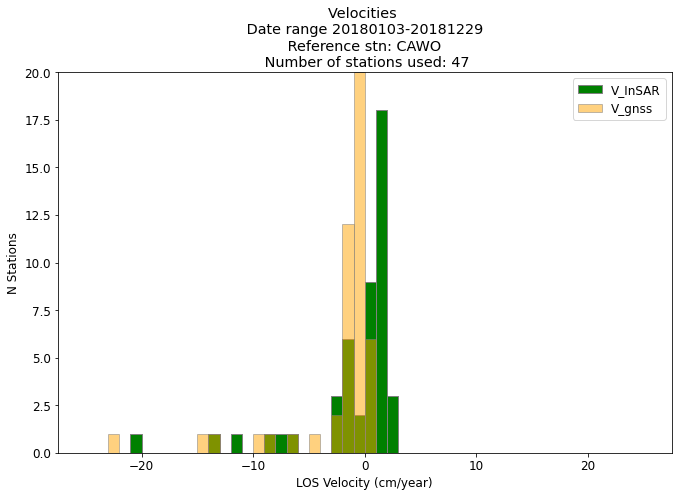

In [27]:
vmin, vmax = -25, 25
plt.figure(figsize=(11,7))
plt.hist(insar_vel, range = [vmin, vmax],bins = 50, color = "green",edgecolor='grey',label='V_InSAR')
plt.hist(gnss_vel, range = [vmin, vmax],bins = 50, color = "orange",edgecolor='grey',label='V_gnss', alpha=0.5)
plt.legend(loc='upper right')
plt.title(f"Velocities \n Date range {start_date}-{end_date} \n Reference stn: {gps_ref_site_name} \n Number of stations used: {num_stn}")
plt.xlabel('LOS Velocity (cm/year)')
plt.ylabel('N Stations')
plt.ylim(0,20)
plt.show()

### A.1.B Plot Velocity Residuals

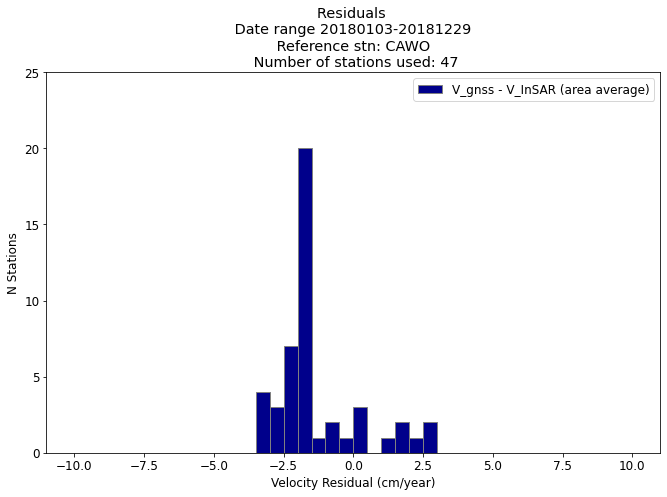

In [28]:
vmin, vmax = -10, 10
plt.figure(figsize=(11,7))
plt.hist(res_list,bins = 40, range = [vmin, vmax],edgecolor='grey',color="darkblue",linewidth=1,label='V_gnss - V_InSAR (area average)')
plt.legend(loc='upper right')
plt.title(f"Residuals \n Date range {start_date}-{end_date} \n Reference stn: {gps_ref_site_name} \n Number of stations used: {num_stn}")
plt.xlabel('Velocity Residual (cm/year)')
plt.ylabel('N Stations')
plt.ylim(0,25)
plt.show()

### A.1.C Plot Double Difference Residuals

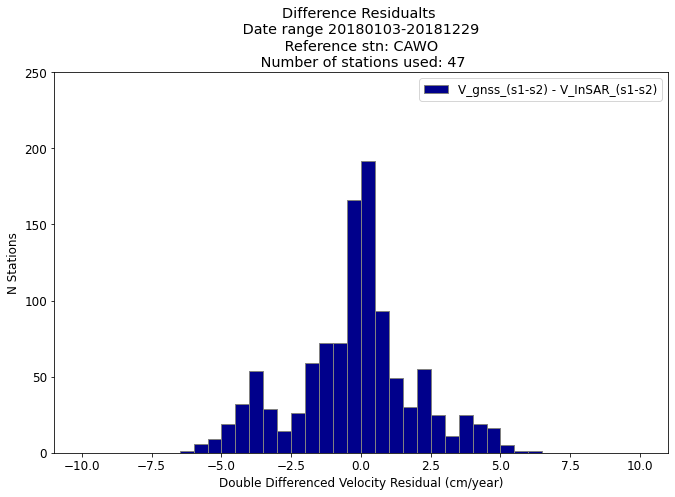

In [29]:
plt.figure(figsize=(11,7))
plt.hist(diff_res_list, range = [vmin, vmax],bins = 40, color = "darkblue",edgecolor='grey',label='V_gnss_(s1-s2) - V_InSAR_(s1-s2)')
plt.legend(loc='upper right')
plt.title(f"Difference Residualts \n Date range {start_date}-{end_date} \n Reference stn: {gps_ref_site_name} \n Number of stations used: {num_stn}")
plt.xlabel('Double Differenced Velocity Residual (cm/year)')
plt.ylabel('N Stations')
plt.ylim(0,250)
plt.show()

### A.1.D  GNSS Timeseries Plots

calculating station lat/lon
reading time and displacement in east/north/vertical direction


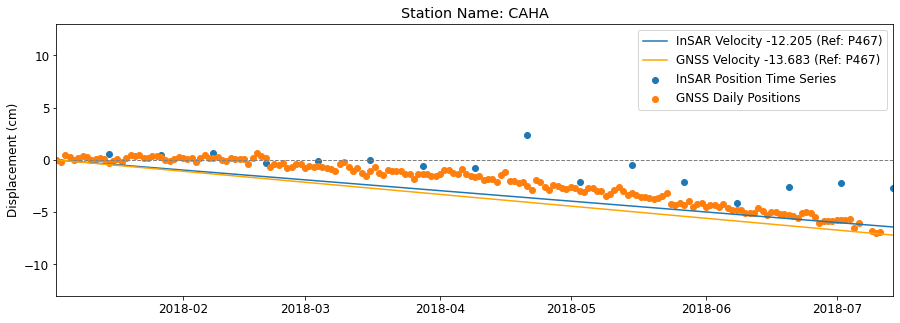

In [210]:
#Read in timeseries file
time_file = os.path.join(work_dir, 'MintPy/timeseries.h5')
insar_displacements = readfile.read(time_file, datasetName='timeseries')[0] * 100.

#Get aquisition dates, trim the str, and convert to datetime
raw_aqu_list = readfile.get_slice_list(time_file)
aquitisions_dates = []
for i in range(len(raw_aqu_list)):
    date = raw_aqu_list[i].split("-")
    #aqu_dates.append = date[1]
    aquitisions_dates.append(dt.strptime(date[1], "%Y%m%d"))
ndates = len(aquitisions_dates)

#Plot displacements and velocity timeseries at GNSS station locations
#test_list = site_names
test_list = ['CAHA'] #', 'CAHA', 'CAKC', 'CAND', 'CARH'] #for testing, remove after
for stn in test_list:
    
    #InSAR Info
    insar_timeseries = []
    stn_x = (stn_dict[stn][0])
    stn_y = (stn_dict[stn][1])
    for i in range(ndates):
        insar_displacement = insar_displacements[i,stn_y,stn_x]
        insar_timeseries.append(insar_displacement)     
    InSAR_stn_vel = stn_dict[stn][2]
    GNSS_stn_vel = stn_dict[stn][3]
    #print(InSAR_stn_vel)
    #print(GNSS_stn_vel)
    
    #get the length of time between first and last interferogram for velocity plotting
    insar_timespan = aquitisions_dates[ndates - 1] - aquitisions_dates[0]
    conversion = insar_timespan.days/365
   
    #Plot InSAR
    plt.figure(figsize=(15,5))  
    plt.plot([0,100000],[0,0], color='grey',linestyle='dashed',linewidth=1)
    plt.scatter(aquitisions_dates, insar_timeseries, label="InSAR Position Time Series")
    #velocity trendline
    plt.plot([aquitisions_dates[0], aquitisions_dates[ndates - 1]],[0,conversion*InSAR_stn_vel],label=f"InSAR Velocity {InSAR_stn_vel:.3f} (Ref: {gps_ref_site_name})")

    #GNSS Info
    gps_obj = GPS(site = stn, data_dir = mint_dir + 'GPS')
    gps_obj.open()
    dates = gps_obj.dates
    head_angle = 90 - az_angle
    disp_los = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u, inc_angle, head_angle, az_angle)
    
    #Plot GNSS
    index_begin = np.min(np.where(dates >= start_date_gnss))
    index_end = np.max(np.where(dates <= end_date_gnss))
    dates_cut = dates[index_begin:index_end]
    disp_los_cut = disp_los[index_begin:index_end]
    disp_los_cut = (disp_los_cut - np.median(disp_los_cut))*100
    plt.scatter(dates_cut, disp_los_cut - disp_los_cut[0], label="GNSS Daily Positions")   
    #velocity trendline
    plt.plot([aquitisions_dates[0], aquitisions_dates[ndates - 1]],[0,conversion*GNSS_stn_vel],color='orange',label=f"GNSS Velocity {GNSS_stn_vel:.3f} (Ref: {gps_ref_site_name})")

    plt.title(f"Station Name: {stn}") 
    plt.ylabel('Displacement (cm)')
    plt.ylim(-13,13)
    plt.xlim(aqu_dates_convert[0],aqu_dates_convert[ndates - 1])
    plt.legend(loc="best")
    